## Stay Safe Local Crime Analysis and Model

This notebook analyzes crime data and models predictions to create awareness of where crimes are likely to occur given historical trends. This is a multinomial classification problem where the prediction has a geographic layer and offense. Offenses can include things like shoplifting, carjacking, and assault.

### Data Source

- **Organization**: Illinois State Police
- **Program**: Illinois Uniform Crime Reporting (I-UCR)
- **Access Point**: [Illinois Crime Analytics Portal](http://lucr.nibrs.com/CrimeAnalytics/index.html)



**Steps Followed:**
1. Load packages and Data
2. API to retrieve latitude and longitude data points
3. Data Preparation
5. Data Exploration and Analysis
6. Feature Engineering
8. Divide data into test and train datasets
9. Use Auto Machine Learning to predict location and offense
11. Use most recent data to predict outcomes


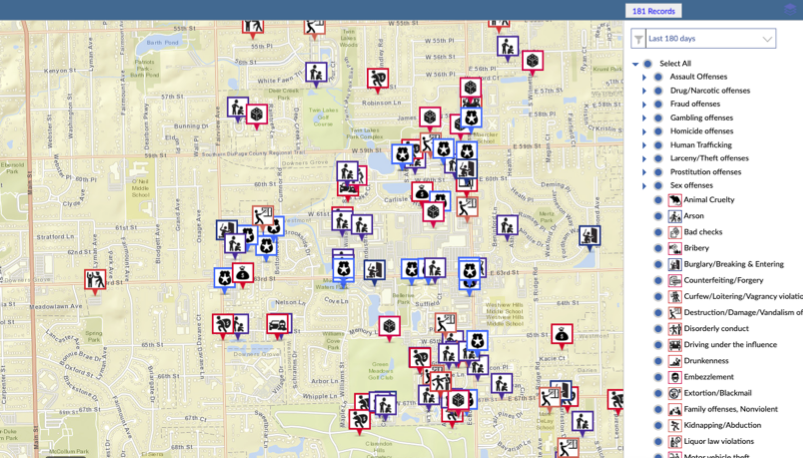

In [53]:
from IPython.display import Image
image_path = 'crime_map_40.png'
image = Image(filename=image_path)
display(image)

### Conclusion:
* Currently, the model is 52% accurate in predicting the city in which an offense will occur in the following month. This metric reflects the number of cases where there was a match across all of the test data. Although this measure is suboptimal, it is better than random chance.
* Precision is quite low for this model, at around 20%. This calculates the weighted average across all predicted classes of correctly identifying classes versus total positive predicted cases. This also indicates that there are quite a few false positives, or instances where the model selected the wrong city. This issue often arises due to class imbalance, particularly in cities with varying crime rates, where the model may frequently misclassify cities with lower crime incidences.
* Recall is even lower, at 17% accuracy, which assesses the actual positive predicted cases against only the positive cases in the data. Class imbalances are significant contributing factors here as well.
### Next Steps and Recommendations:
* Acquire more data. Ideally, the test-train set should include at least 2,000 observations. This may require expanding to adjacent zip codes or comparing similar zip codes.
* Incorporate population data metrics. Currently, the analysis of zip codes is conducted in isolation. To evaluate the performance of these metrics, reference to state or national statistics for comparison could provide valuable context.
* Include additional data points such as demographics by zip code.
* Examine population density. Preliminary observations suggest that crime is concentrated in highly populated areas, such as apartment complexes and retail centers.
* Further investigate correlations to latitude and longitude to potentially uncover geographic patterns in crime distribution.

### Load packages and Data

In [2]:
#pip install seaborn
import sys
if '/home/sagemaker-user' not in sys.path:
    sys.path.append('/home/sagemaker-user')
from config import api_key   
import pandas as pd
import requests
import time
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from autogluon.tabular import TabularPredictor
import numpy as np
import warnings
warnings.filterwarnings('ignore')

df = pd.read_excel('Crime Map Offense Report_2024-02-20T21_11_06-06_00.xlsx', skiprows = 2)

### API to retrieve latitude and longitude data points

In [ ]:
df['Latitude'] = None
df['Longitude'] = None

def geocode_address(address, api_key):
    base_url = "https://geocode.maps.co/search"
    params = {
        'q': address,
        'api_key': api_key } 
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        if data:
            return data[0]['lat'], data[0]['lon']
    return None, None
counter = 0  # Initialize the counter
for index, row in df.iterrows():  
    try:
        lat, lon = geocode_address(row['Address'], api_key)  
        if lat and lon:
            df.at[index, 'Latitude'] = lat
            df.at[index, 'Longitude'] = lon
            counter += 1
            print(f"{row['Address']} - Latitude: {lat}, Longitude: {lon}")
        time.sleep(1.2)  
    except Exception as e:
        print(f"Error geocoding address {row['Address']}: {e}")
print(f"Total records processed: {counter}")

### Data Preparation

In [54]:
# Standardizing column names 
df.columns = [str.lower(e).replace(' ', '_') for e in df.columns]
# Dropping indistinguishable, or non-applicable ZIP Codes
df = df.loc[df['zip_code'].notnull()]
# Changing zipcode type to int vs. float
df.loc[:, 'zip_code'] = df.loc[:, 'zip_code'].astype(int)
# Changing incident_date from string to date format
df['incident_date'] = pd.to_datetime(df['incident_date'], format='%a %b %d %Y')
# Adding year month vector
df['year_month'] = pd.to_datetime(df['incident_date'].dt.strftime('%Y-%m'))
# Storing data for future use
df.to_csv('crime_map_data.csv', index=None)

### Data Exploration and Analysis

In [24]:

cmd = pd.read_csv('crime_map_data.csv', parse_dates=['incident_date'])

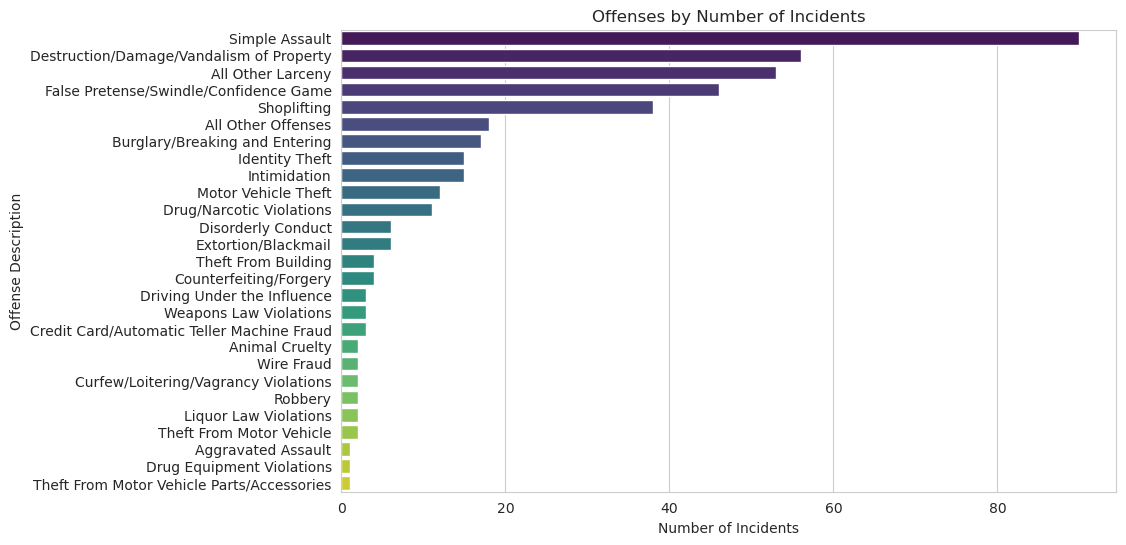

In [25]:
# Histogram of Offenses by Number of incidents 
offense_counts = cmd.groupby('offense_description')['incident_number'].nunique().reset_index(name='incident_count').sort_values('incident_count', ascending = False)
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='incident_count', y='offense_description', hue='offense_description',
            data=offense_counts, palette='viridis', dodge=False, legend=False)
plt.legend([],[], frameon=False)
plt.title('Offenses by Number of Incidents')
plt.xlabel('Number of Incidents')
plt.ylabel('Offense Description')
plt.show()

In [26]:
# Limiting Scatter plots to top 7 offenses and grouping by offence and year/month with a count of # of incidents
offense_counts_date = cmd[cmd['offense_description'].isin(offense_counts[0:7].offense_description.values)].groupby(['offense_description','year_month'])['incident_number'].nunique().reset_index(name='incident_count') \
    .sort_values('incident_count', ascending = False)
offense_counts_date['year_month'] = pd.to_datetime(offense_counts_date['year_month'], format='%Y-%m-%d')
offense_counts_date['year_month_numeric'] = offense_counts_date['year_month'].apply(lambda x: mdates.date2num(x))

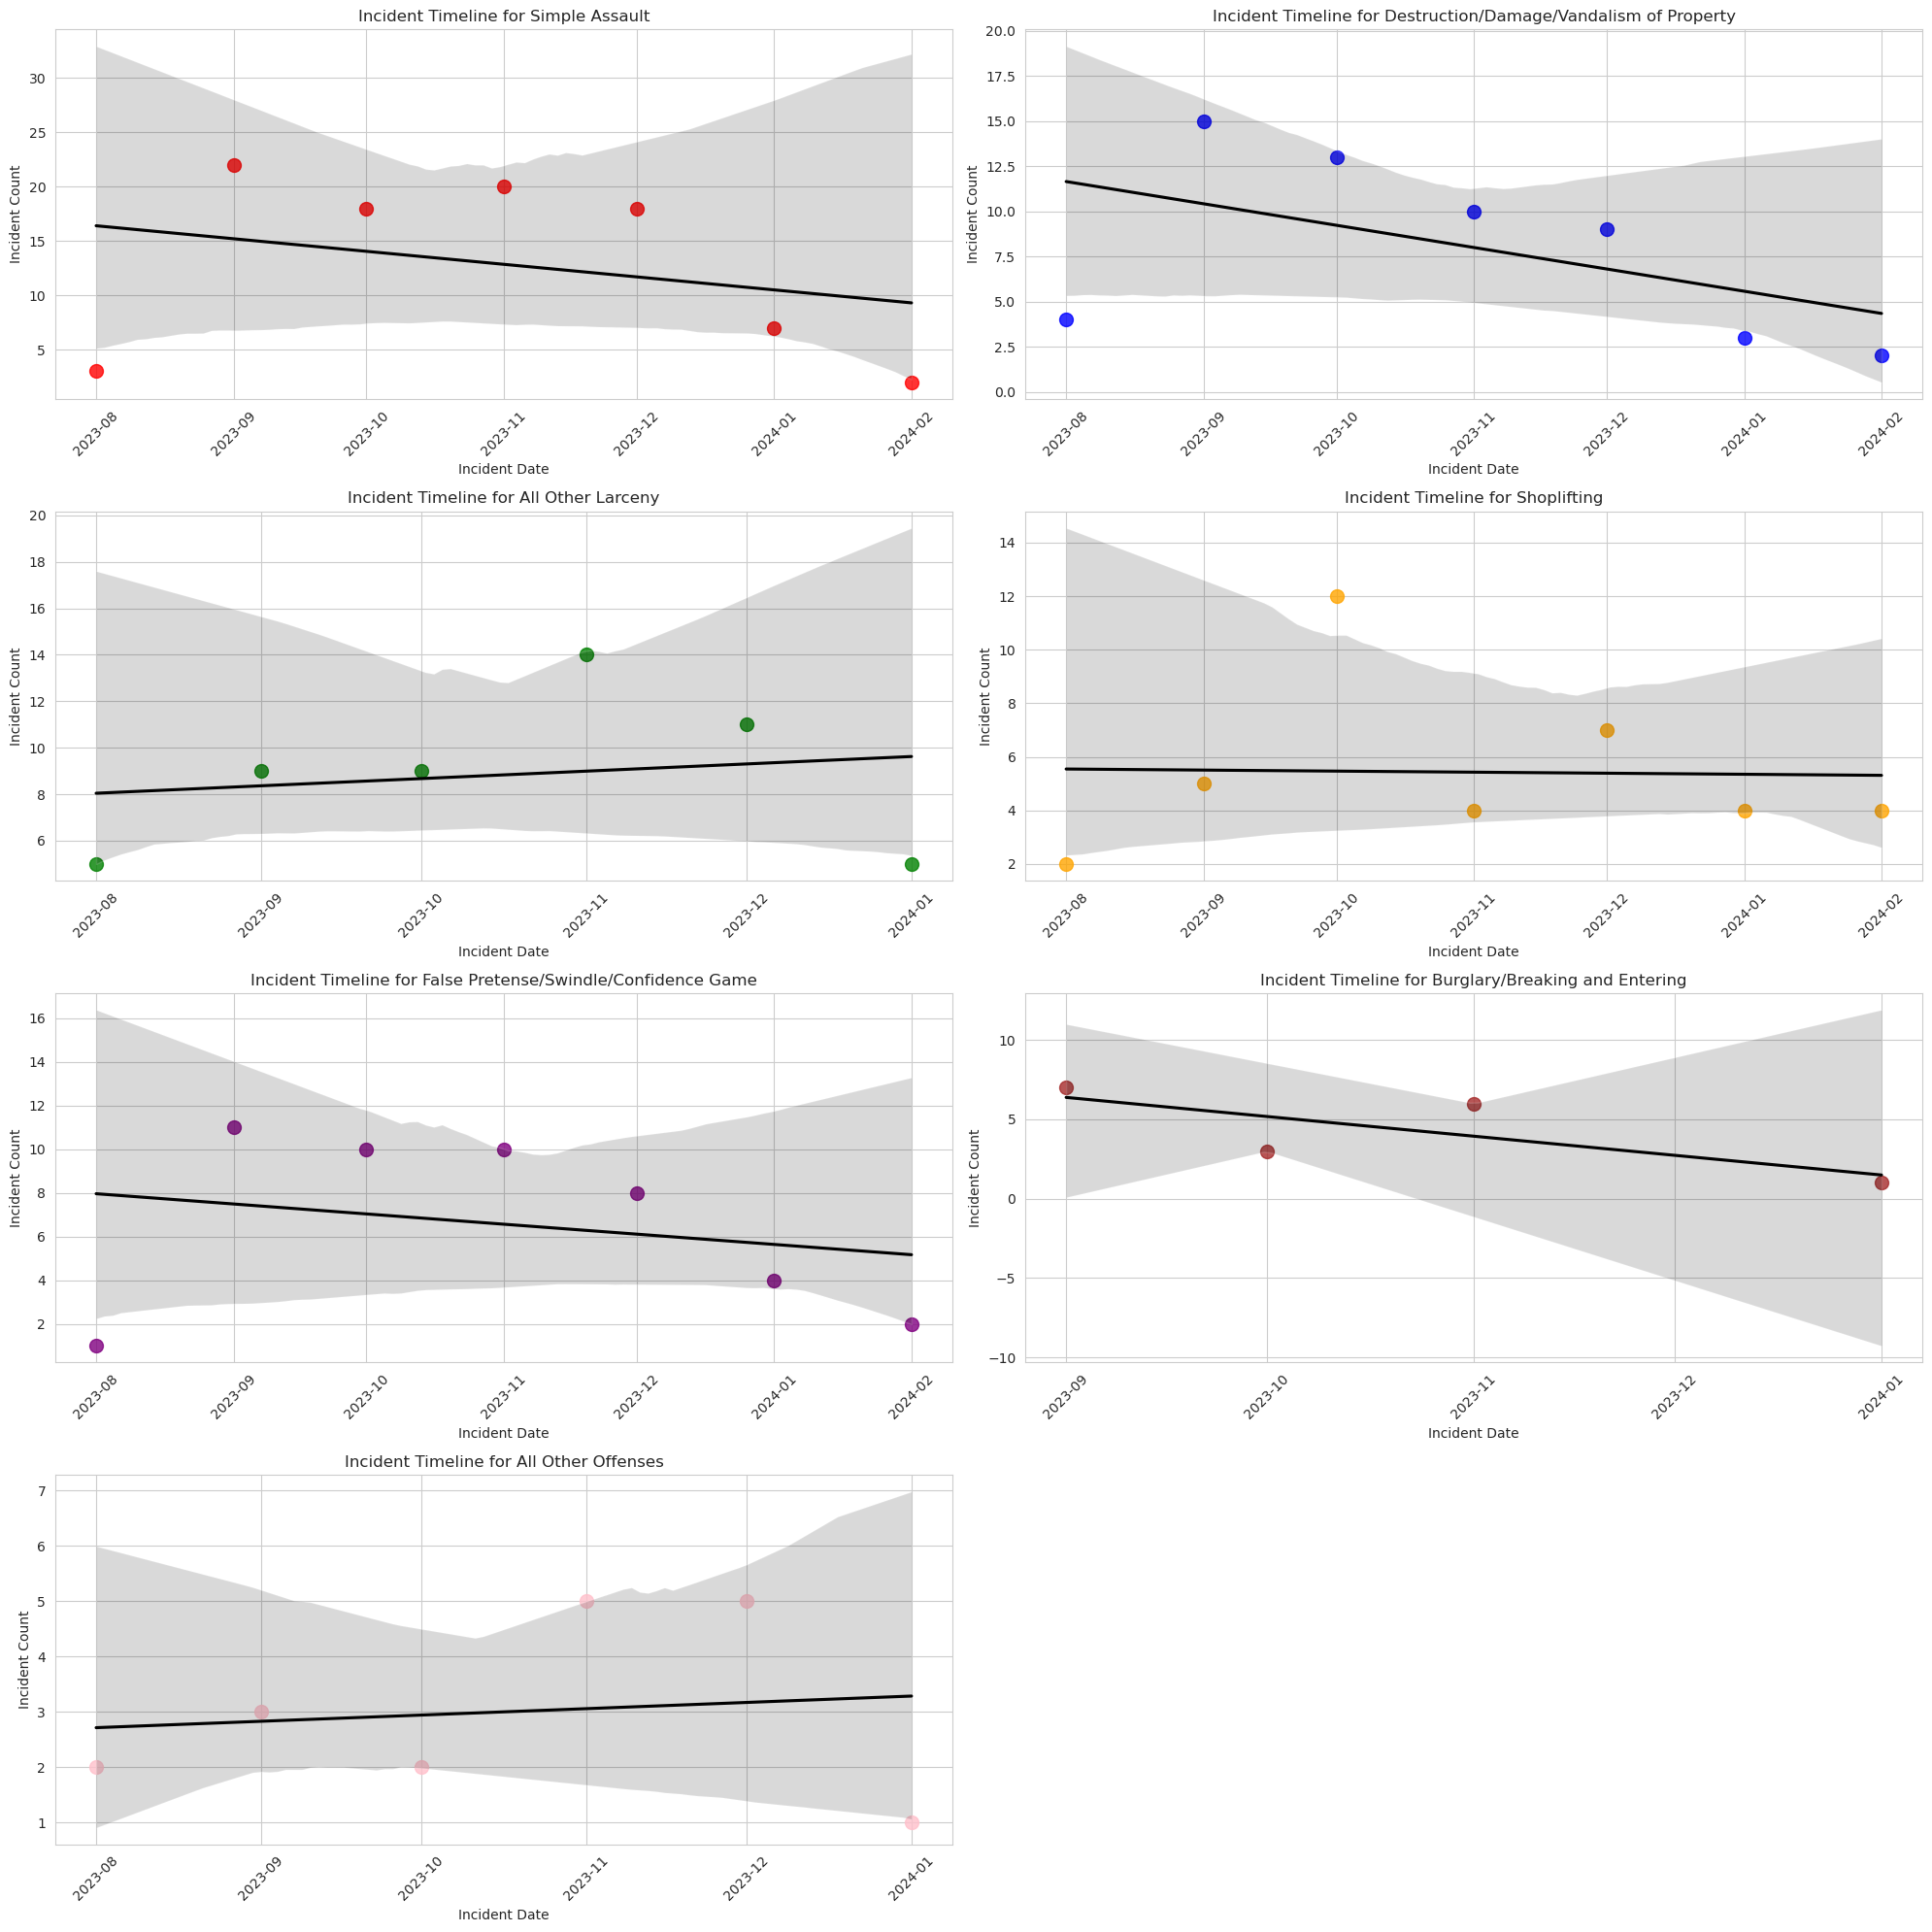

In [27]:
# Creating intrest in the plots by adding color
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink']  
plt.figure(figsize=(20, 20))
# Loop through each unique offense description and create a plot
for i, offense in enumerate(offense_counts_date.offense_description.unique(), start=1):
    plt.subplot(4, 2, i)  
    subset = offense_counts_date[offense_counts_date['offense_description'] == offense]
    sns.regplot(data=subset, x='year_month_numeric', y='incident_count', scatter_kws={'s': 100}, line_kws={'color': 'black'}, color=colors[i-1])
    plt.title(f'Incident Timeline for {offense}')
    plt.xlabel('Incident Date')
    plt.ylabel('Incident Count')
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.tight_layout()
plt.show()

### Data Exploration and Analysis Observations:
* Most offenses around the 60516 zip code are assault by far, with over 85 incidents accounting for 22% of all incidents. This is followed by Destruction/Damage/Vandalism of Property at 13%.
* The top 7 offenses account for 77% of all the incidents in 60516.
* Most of the top 7 are trending down, with the exception of Larceny. This one has trended up in recent months.
* Simple assault, damage/vandalism, and burglary have notably gone down in recent months.

### Feature Engineering
1) Structure the data in such a way that the model can draw correlations in columnar data.
2) Create new features based on past data (1, 2, and 3 months ago) at the offense level for specific timeframes. This approach will emphasize the significance of the offense at specified times, regardless of location.

In [28]:
#rename offenses for feature enginerring operations. 
cmd['offense_description2'] = cmd['offense_description'].apply(lambda x: str.lower(x).strip().replace('/','_').replace(' ','_') )
# Creating the predictive target
cmd['target'] = cmd['city']

In [29]:
#Put data into feature engineered formatting structure for the model
feature_transform = cmd.pivot_table(
    index=['incident_date','year_month','target','offense_description2'],  
    columns='offense_description', 
    values='incident_number',  
    aggfunc='nunique'  
).reset_index().fillna(0)
#rename columns for clarity
feature_transform.columns = [str.strip(str.lower(e).replace('/','_').replace(' ','_')) for e in feature_transform.columns]
# Creating log transformations of offenses 
cat_ttl = cmd[['incident_date','year_month','offense_description',]].copy()
cat_ttl['offense_description'] = cat_ttl['offense_description'].apply(lambda x: str.lower(x).strip().replace('/','_').replace(' ','_') )
cat_ttl['incident_date'] = pd.to_datetime(cat_ttl['incident_date'])
cat_ttl.set_index('incident_date', inplace=True)
cat_ttl['counts'] = 1
cat_ttl['1_month_ago_count'] = cat_ttl.groupby(['offense_description'])['counts'] \
.transform(lambda x: x.rolling(window=1, min_periods=1).sum().shift(1))
cat_ttl['1_month_ago_count'] = cat_ttl.groupby(['offense_description'])['counts'].transform(lambda x: x.rolling(window=1, min_periods=1).sum().shift(1))
cat_ttl['2_months_ago_count'] = cat_ttl.groupby(['offense_description'])['counts'].transform(lambda x: x.rolling(window=2, min_periods=1).sum().shift(2))
cat_ttl['3_months_ago_count'] = cat_ttl.groupby(['offense_description'])['counts'].transform(lambda x: x.rolling(window=3, min_periods=1).sum().shift(3))
cat_ttl.rename(columns = {'offense_description':'offense_description2'}, inplace = True)

### Divide data into test and train datasets

In [30]:
model_test = feature_transform.merge(cat_ttl.drop('year_month',axis = 1), on = ['incident_date','offense_description2'], how = 'left') \
    .drop(['incident_date','year_month','offense_description2'],axis = 1)
train_data, test_data = train_test_split(model_test, test_size=0.2, random_state=42)

In [31]:
model_test

,target,aggravated_assault,all_other_larceny,all_other_offenses,animal_cruelty,burglary_breaking_and_entering,counterfeiting_forgery,credit_card_automatic_teller_machine_fraud,curfew_loitering_vagrancy_violations,destruction_damage_vandalism_of_property,...,simple_assault,theft_from_building,theft_from_motor_vehicle,theft_from_motor_vehicle_parts_accessories,weapons_law_violations,wire_fraud,counts,1_month_ago_count,2_months_ago_count,3_months_ago_count
0,DARIEN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,2.0,3.0
1,DARIEN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1,1.0,1.0,NaN
2,LISLE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,2.0,3.0
3,WILLOWBROOK,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,2.0,3.0
4,DARIEN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472,DARIEN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,NaN,NaN
473,DARIEN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN,NaN,NaN
474,DARIEN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1,NaN,NaN,NaN
475,DARIEN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN,NaN,NaN


### Use Auto Machine Learning to predict location and offense

In [40]:
# Define the column name of your target variable
label = 'target'
predictor = TabularPredictor(label=label, eval_metric='accuracy').fit(train_data=train_data)
performance = predictor.evaluate(test_data)
# Make predictions
predictions = predictor.predict(test_data.drop(columns=[label]))

No path specified. Models will be saved in: "AutogluonModels/ag-20240226_134541"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20240226_134541"
AutoGluon Version:  0.8.2
Python Version:     3.10.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Jan 12 09:58:17 UTC 2024
Disk Space Avail:   5.05 GB / 5.36 GB (94.2%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    431
Train Data Columns: 31
Label Column: target
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == object).
	10 unique label values:  ['DARIEN', 'LISLE', 'WILLOWBROOK', 'CLARENDON HILLS', 'WESTMONT', 'DOWNERS GROVE', 'WOODRIDGE', 'Darien', 'Downers Grove', 'Woodridge']
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: 

In [45]:
# View Leaderboard
leaderboard = predictor.leaderboard(test_data)

                  model  score_test  score_val  pred_time_test  pred_time_val  fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       NeuralNetFastAI    0.520833   0.500000        0.024626       0.010400  0.884155                 0.024626                0.010400           0.884155            1       True          3
1   WeightedEnsemble_L2    0.520833   0.500000        0.026913       0.011122  1.699315                 0.002287                0.000722           0.815160            2       True         14
2               XGBoost    0.489583   0.486842        0.037619       0.004945  0.441760                 0.037619                0.004945           0.441760            1       True         11
3              LightGBM    0.479167   0.486842        0.012187       0.010538  0.474711                 0.012187                0.010538           0.474711            1       True          5
4            LightGBMXT    0.479167   0.48684

In [42]:
#Evalue key metrics from the model
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
y_true_binarized = label_binarize(y_true, classes=np.unique(y_true))
y_pred_binarized = label_binarize(y_pred, classes=np.unique(y_pred))
auc = roc_auc_score(y_true_binarized, y_pred_binarized, average='macro', multi_class='ovr')

print(f"Accuracy: {accuracy}")
print(f"Precision (Macro): {precision}")
print(f"Recall (Macro): {recall}")
print(f"F1 Score (Macro): {f1}")
print(f"AUC (One-vs-Rest): {auc}")

Accuracy: 0.5208333333333334
Precision (Macro): 0.1963370901639344
Recall (Macro): 0.17547348484848485
F1 Score (Macro): 0.16382058535523883
AUC (One-vs-Rest): 0.4669228858399019


### Use most recent data to predict outcomes

In [34]:
#now that we know model perfocmace on randomized data, lets break traning data ub by historical and more recent
train_data = feature_transform.merge(cat_ttl.drop('year_month',axis = 1), on = ['incident_date','offense_description2'], how = 'left') \
    .query("incident_date < '2024-01-01'") \
    .drop(['incident_date','year_month','offense_description2'],axis = 1)
predict_data = feature_transform.merge(cat_ttl.drop('year_month',axis = 1), on = ['incident_date','offense_description2'], how = 'left') \
    .query("incident_date >= '2024-01-01'") \
    .drop(['incident_date','year_month','offense_description2'],axis = 1)

In [50]:
#loading established model and predicting on Latest data
model_directory = 'AutogluonModels/ag-20240226_133603'
predictor = TabularPredictor.load(model_directory)
pred = predictor.predict(predict_data)
final_predictions = predict_data[['target']].merge(pred, left_index = True, right_index = True, suffixes = ['_predicted','_acutal'])
final_predictions.head(50)

,target_predicted,target_acutal
431,DARIEN,DARIEN
432,WILLOWBROOK,DARIEN
433,DARIEN,WESTMONT
434,DARIEN,DARIEN
435,DARIEN,WESTMONT
436,DARIEN,DARIEN
437,DARIEN,WESTMONT
438,DARIEN,WESTMONT
439,WILLOWBROOK,WESTMONT
440,WILLOWBROOK,WESTMONT


## Conclustion:
* Currenlty the model is 52% accurate in predicting which city an offence will occurr in the following month. This metric considers how many cases there was a match across all of the test data.  This measure is sub otomial but better than random chance.
* Percision is quite low for this model at around 20%.  This takes weightted average across all predicated classes of correctly identifiying classes vs. total positive predicted casess.  This also indicates that there are quite a few false positives or instances where the model picked the wrong city. Because some citys do not have the same amount of crime when the model dos not pick up on that and for that city it gets it wrong most of the time for example.  This is a classic case of class imballance.
* Recall is even lower at 17% accurate wich looks at actual positive predicted cases to only positive cases in the data.  Again class imballance are driving factors here.

## Next steps and reccomendations:
1) Get more data. I would like to see at least 2,000 oberservations in the test train set.  This may mean expanding ot other ajacent zipcodes or comparing simmular zipcodes.
2) Get population data metrics.  This zipcode search is done in isolation. To compare how good or bad a metric is we need refrences to perhaps state or national sttastics for comparesion.
3) Bring in other data points such a demographics by zipcode.
4) Look at poplulation density.  Eballing the map it looks like crime is concentrated around highly populated areas such as appartment complexes and retail.
5) Delve more into corrliatoins to lattitue and logitude. 